# Staff Planning Case Study

##### Problem Introduction

An insurance company InsurePlus wants help with finding the optimal number of staff that they need for their insurance application approval process for the calendar year 2021.  In the industry, the number of staffs is considered as a continuous variable. This is also called a Full-Time Equivalent (FTE) of the staff. For example, if a full-time employee (FTE =1) works for 50 hours a week, 10 hours corresponds to 0.2 FTEs. If the pay for 50 hours a week is $ 5000, then 0.2 FTE who may be a part-time employee will be paid $ 1000 (5000*0.2). The information provided are as follows.

##### Problem Statement and Background

- The company operates in three states: A, B and C. The state-wise demand for insurance for the year is shown in the table provided below:
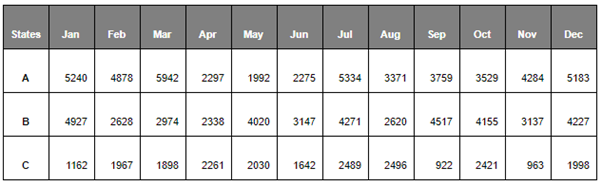
The company can either handle an application with the staff that they hire or outsource it to a vendor. Assume that there is no capacity limitation to outsourcing.
- If they hire staff, he/she can handle 40 insurance applications per month when he/she works 100% of the workdays. However, there are days that he/she will be unavailable to process applications due to training, off days, etc. 
- A staff member’s availability (in percentage) to work on processing the insurance applications for each month is shown in the table given below. As mentioned before, with 100% availability, each member can handle 40 applications.
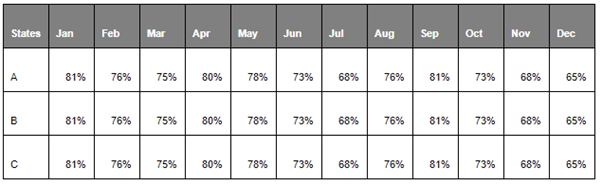
           
        
- States A and B have a regulatory restriction that the outsourced insurance applications cannot be more than 30% and 40% of the total number of applications for each month, respectively. 
- The table given below shows the cost of the staff vs external resources:
 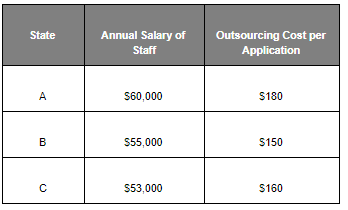                                            
 
The objective is to optimise the total cost for the application approval process by distributing the right number of applications between the FTEs and the vendors while meeting the monthly demand for each state at the same time.





In [1]:
# Importing Libraries 

import pandas as pd
import numpy as np
import math
from pyomo.environ import *

In [2]:
from __future__ import division
from pyomo.opt import SolverFactory

In [3]:
# Reading the data from Excel workbook

InputData = "Staffing+Data.xlsx"

StaffAV = pd.read_excel(InputData,sheet_name = "StaffAvailability")
Cost = pd.read_excel(InputData, sheet_name = "Cost")
transcost = pd.read_excel(InputData,sheet_name = "ServiceRate")
MgDemandDist = pd.read_excel(InputData,sheet_name = "DemandData")



## Data pre-processing 

In [4]:
# Create the required Python data structures for indexes and parameters

MgDemandDist.head()


,State,Month,Demand
0,A,Jan,5240
1,A,Feb,4878
2,A,Mar,5942
3,A,Apr,2297
4,A,May,1992


In [5]:
StaffAV.head()

,State,Month,LB,UB,StaffAvPer
0,A,Jan,0.70,0.90,0.81
1,A,Feb,0.65,0.85,0.76
2,A,Mar,0.70,0.80,0.75
3,A,Apr,0.75,0.85,0.80
4,A,May,0.70,0.85,0.78


In [6]:
Cost.head()

,State,Month,AnnualSalary,MonthlySalary,UnitOutSourceCost
0,A,Jan,60000,5000.0,180
1,A,Feb,60000,5000.0,180
2,A,Mar,60000,5000.0,180
3,A,Apr,60000,5000.0,180
4,A,May,60000,5000.0,180


In [7]:
transcost.head()

,MgAppServedPerMonth
0,40


In [8]:
# Create the required Python data structures for indexes and parameters

# Demand Data

Demand = MgDemandDist.set_index(["State","Month"])["Demand"].to_dict()

# FTE Salary from the data

FTE_Salary = Cost.set_index(["State","Month"])["MonthlySalary"].to_dict()

# Unit outsourcing cost

UnitOutSourceCost = Cost.set_index(["State","Month"])["UnitOutSourceCost"].to_dict()

# Number of applications when working full time

FTE_AppServeRate = transcost.iloc[0,0]

# Staff availability for serving  the Insurance Application

StaffAv_LB = StaffAV.set_index(["State","Month"])["LB"].to_dict()
StaffAv_UB = StaffAV.set_index(["State","Month"])["UB"].to_dict()
StaffAvPer = StaffAV.set_index(["State","Month"])["StaffAvPer"].to_dict()

# 6 Index

BankLoc = Cost["State"].unique()
Month = Cost["Month"].unique()

In [9]:
Demand

{('A', 'Jan'): 5240,
 ('A', 'Feb'): 4878,
 ('A', 'Mar'): 5942,
 ('A', 'Apr'): 2297,
 ('A', 'May'): 1992,
 ('A', 'Jun'): 2275,
 ('A', 'Jul'): 5334,
 ('A', 'Aug'): 3371,
 ('A', 'Sep'): 3759,
 ('A', 'Oct'): 3529,
 ('A', 'Nov'): 4284,
 ('A', 'Dec'): 5183,
 ('B', 'Jan'): 4927,
 ('B', 'Feb'): 2628,
 ('B', 'Mar'): 2974,
 ('B', 'Apr'): 2338,
 ('B', 'May'): 4020,
 ('B', 'Jun'): 3147,
 ('B', 'Jul'): 4271,
 ('B', 'Aug'): 2620,
 ('B', 'Sep'): 4517,
 ('B', 'Oct'): 4155,
 ('B', 'Nov'): 3137,
 ('B', 'Dec'): 4227,
 ('C', 'Jan'): 1162,
 ('C', 'Feb'): 1967,
 ('C', 'Mar'): 1898,
 ('C', 'Apr'): 2261,
 ('C', 'May'): 2030,
 ('C', 'Jun'): 1642,
 ('C', 'Jul'): 2489,
 ('C', 'Aug'): 2496,
 ('C', 'Sep'): 922,
 ('C', 'Oct'): 2421,
 ('C', 'Nov'): 963,
 ('C', 'Dec'): 1998}

In [10]:
BankLoc.tolist()

['A', 'B', 'C']

### Decision Variables and Objective Function
The company wants to know the optimised staffing recommendations for the business case described. 
Write the mathematical model for the deterministic optimisation problem. Define and explain your decision variables, objective function and the constraint. (Hint: Use months of the year as the model timeline).

**Decision variables:**


- Number of FTEs required <br>

x
- Number of Applications to be outsourced <br>

y

---

**Objective:**

To *minimize* the sum of cost involved for FTEs and outsourced applications across all the locations (A, B, C) and for all the months. 

\begin{align}
\textrm {min}\sum \limits _{s,m} \text {X}_{s,m} * \text {S}_{s,m} + \text {Y}_{s,m}* \text {C}_{s,m}
\end{align}

Where <br>
X = Number of FTEs <br>
Y = Number of outsourced applications <br>
S = Salary for the FTE <br>
C = Unit Cost for the outsourced application <br>
s = state <br>
m = month <br>

---

### Model - 1 (Average Availabilty of Staff)

In [11]:
# Model object

model = ConcreteModel()

# Define sets

model.i = Set(initialize =BankLoc.tolist(), doc = "State")
model.j = Set(initialize =Month.tolist(), doc = "Months")

In [12]:
#  Define parameters

model.d = Param(model.i,model.j,initialize = Demand, doc = "Demand")
model.s = Param(model.i,model.j,initialize = FTE_Salary, doc = "FTE_Salary")
model.oc = Param(model.i,model.j,initialize = UnitOutSourceCost, doc = "UnitOutSourceCost")
model.sa = Param(model.i,model.j,initialize = StaffAvPer, doc = "StaffAvPercent")
model.lb = Param(model.i,model.j,initialize = StaffAv_LB, doc = "StaffAv_LB")
model.ub = Param(model.i,model.j,initialize = StaffAv_UB, doc = "StaffAv_UB")

In [13]:
# Scalar Application Service rate when working 100%

model.r = Param(initialize = FTE_AppServeRate, doc = "FTE App Serve Rate")

In [14]:
# parameter for the number of applications that can be processed for the given staff availability

def c_FTEAPP(model, i, j):
    return model.r*model.sa[i,j]

model.FTEAPPNO = Param(model.i,model.j,initialize = c_FTEAPP, doc = "NO OF FTE APP")

    

In [15]:
# Parameter for restriction on the number of outsourced applications for state A and B 

# the regulatory constarint for State A i.e 30% of Demand

def Reg_A(model,i,j):
    return 0.30*model.d[i,j]


model.reg_A = Param(model.i,model.j,initialize = Reg_A, doc = "RegRest_A")


# the regulatory constraint for State B i.e 40% of Demand

def Reg_B(model,i,j):
    return 0.40*model.d[i,j]

model.reg_B = Param(model.i,model.j,initialize = Reg_B, doc = "RegRest_B")

In [16]:
# Decision Variable

model.x = Var(model.i, model.j, domain = NonNegativeReals, doc = "No of FTE")
model.y = Var(model.i, model.j, domain = NonNegativeIntegers, doc = "No of Outsourced App")


In [17]:
# Define Contraint using ConstraintList

# Demand constraints

model.demand_constraint = ConstraintList()

for i in model.i:
    for j in model.j:
        model.demand_constraint.add(expr= model.x[i,j] * model.FTEAPPNO[i,j] + model.y[i,j] == model.d[i,j])
    

In [18]:
# Regulatory constraints on number of Outsourced Applications

model.regulatoryCons = ConstraintList()

for i in model.i:
    for j in model.j:
        if i == "A":
            model.regulatoryCons.add(expr = model.y["A",j]<= model.reg_A["A",j])
        elif i == "B":
            model.regulatoryCons.add(expr = model.y["B",j]<= model.reg_B["B",j])

In [19]:
# # Define Objective Function i.e. Total Cost

def objective_rule(model):
    return sum(model.s[i,j]*model.x[i,j] for i in model.i for j in model.j) +\
           sum(model.oc[i,j]*model.y[i,j] for i in model.i for j in model.j)

model.objective = Objective(rule = objective_rule, sense = minimize, doc = "Define Objective Function")



In [20]:
result_cost = SolverFactory("glpk").solve(model)

result_cost.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 17962336.4487699
  Upper bound: 17962336.4487699
  Number of objectives: 1
  Number of constraints: 61
  Number of variables: 73
  Number of nonzeros: 97
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.13443422317504883
# ----------------------------------------------------------
#   Solution Information
# ------------

In [21]:
print(model.x["A","Dec"].value)

# This will display the value of the variable x i.e. the number of FTE
# for state A Dec Month

139.576923076923


In [22]:
print(model.y['A','Dec'].value)
# This will display the value of the variable y i.e. the number of outsourced applications
# for state A Dec Month ->

1554.0


In [23]:
Total_Cost = round(model.objective.expr(), 2)

In [24]:
Total_Cost

17962336.45

In [25]:
# Creating dataframe for the results

FTEstaff = []
for i in BankLoc:
    for j in Month:
        d = model.d[i,j] #demand
        v = model.x[i,j].value # FTE
        w = model.y[i,j].value # App_outsourced
        n = model.x[i,j].value*40*model.sa[i,j] #no of app processed by FTE
        c = model.x[i, j].value*FTE_Salary[i, j] + model.y[i, j].value*UnitOutSourceCost[i, j]
        p_w = round((w/d)*100,2) # percent outsourced
        avg_cost_app = round(c/d, 2)
        FTEstaff.append([i,j,d,v,w, n,c, p_w, avg_cost_app])

output = pd.DataFrame(FTEstaff, columns =['BankLoc', "Month", 'Demand',"FTE", "App_Outsourced", "App_Proc_FTE", "Cost", "Percent_Outsourced", 
                                         "Avg_CostperApp"])
        
output

,BankLoc,Month,Demand,FTE,App_Outsourced,App_Proc_FTE,Cost,Percent_Outsourced,Avg_CostperApp
0,A,Jan,5240,161.728395,0.0,5240.0,808641.975309,0.00,154.32
1,A,Feb,4878,160.460526,0.0,4878.0,802302.631579,0.00,164.47
2,A,Mar,5942,198.066667,0.0,5942.0,990333.333333,0.00,166.67
3,A,Apr,2297,71.781250,0.0,2297.0,358906.250000,0.00,156.25
4,A,May,1992,63.846154,0.0,1992.0,319230.769231,0.00,160.26
5,A,Jun,2275,77.910959,0.0,2275.0,389554.794521,0.00,171.23
6,A,Jul,5334,137.279412,1600.0,3734.0,974397.058824,30.00,182.68
7,A,Aug,3371,110.888158,0.0,3371.0,554440.789474,0.00,164.47
8,A,Sep,3759,116.018519,0.0,3759.0,580092.592593,0.00,154.32
9,A,Oct,3529,120.856164,0.0,3529.0,604280.821918,0.00,171.23


In [26]:
output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   BankLoc             36 non-null     object 
 1   Month               36 non-null     object 
 2   Demand              36 non-null     int64  
 3   FTE                 36 non-null     float64
 4   App_Outsourced      36 non-null     float64
 5   App_Proc_FTE        36 non-null     float64
 6   Cost                36 non-null     float64
 7   Percent_Outsourced  36 non-null     float64
 8   Avg_CostperApp      36 non-null     float64
dtypes: float64(6), int64(1), object(2)
memory usage: 2.7+ KB


In [27]:
output = output.round({"FTE": 1, "App_Outsourced": 0, "Cost": 2})

output.head()

,BankLoc,Month,Demand,FTE,App_Outsourced,App_Proc_FTE,Cost,Percent_Outsourced,Avg_CostperApp
0,A,Jan,5240,161.7,0.0,5240.0,808641.98,0.0,154.32
1,A,Feb,4878,160.5,0.0,4878.0,802302.63,0.0,164.47
2,A,Mar,5942,198.1,0.0,5942.0,990333.33,0.0,166.67
3,A,Apr,2297,71.8,0.0,2297.0,358906.25,0.0,156.25
4,A,May,1992,63.8,0.0,1992.0,319230.77,0.0,160.26


In [28]:
total_demand = sum(output["Demand"])

total_FTE = sum(output["FTE"])

total_outsourced_app = sum(output["App_Outsourced"])

total_cost = sum(output["Cost"])

Avg_FTE = round(output["FTE"].mean(), 2)

Avg_cost_per_app = round(total_cost/total_demand, 2)

perc_outsourced_app = round(total_outsourced_app/total_demand, 2)

print("Total Demand: ", total_demand)
print("Total Outsourced Application: ", total_outsourced_app)
print("Total FTE: ", total_FTE)
print("Avg FTE: ", Avg_FTE)
print("Estimated Cost: ", total_cost)




Total Demand:  113294
Total Outsourced Application:  20749.0
Total FTE:  3085.7999999999993
Avg FTE:  85.72
Estimated Cost:  17962336.439999998


# Worst-case and best-case analysis based on the staffs' availability.

### Lower Bound Model

In [29]:
# Model object

model_lb = ConcreteModel()

# Define sets

model_lb.i = Set(initialize =BankLoc.tolist(), doc = "State")
model_lb.j = Set(initialize =Month.tolist(), doc = "Months")

In [30]:
#  Define parameters

model_lb.d = Param(model.i,model.j,initialize = Demand, doc = "Demand")
model_lb.s = Param(model.i,model.j,initialize = FTE_Salary, doc = "FTE_Salary")
model_lb.oc = Param(model.i,model.j,initialize = UnitOutSourceCost, doc = "UnitOutSourceCost")
model_lb.sa = Param(model.i,model.j,initialize = StaffAvPer, doc = "StaffAvPercent")
model_lb.lb = Param(model.i,model.j,initialize = StaffAv_LB, doc = "StaffAv_LB")


In [31]:
# Scalar Application Service rate when working 100%

model_lb.r = Param(initialize = FTE_AppServeRate, doc = "FTE App Serve Rate")

In [32]:
# parameter for the number of applications that can be processed for the given staff lower bound

def c_FTEAPP_lb(m, i, j):
    return m.r*m.lb[i,j]

model_lb.FTEAPPNO_lb = Param(model_lb.i,model_lb.j,initialize = c_FTEAPP_lb, doc = "NO OF FTE APP")

In [33]:
# Parameter for restriction on the number of outsourced applications for state A and B 

# the regulatory constarint for State A i.e 30% of Demand

def Reg_A_lb(m,i,j):
    return 0.30*m.d[i,j]


model_lb.reg_A_lb = Param(model_lb.i,model_lb.j,initialize = Reg_A_lb, doc = "RegRest_A")


# the regulatory constraint for State B i.e 40% of Demand

def Reg_B_lb(m,i,j):
    return 0.40*m.d[i,j]

model_lb.reg_B_lb = Param(model_lb.i,model_lb.j,initialize = Reg_B_lb, doc = "RegRest_B")

In [34]:
# Decision Variable

model_lb.x = Var(model_lb.i, model_lb.j, domain = NonNegativeReals, doc = "No of FTE")
model_lb.y = Var(model_lb.i, model_lb.j, domain = NonNegativeIntegers, doc = "No of Outsourced App")

In [35]:
# Define Contraint using ConstraintList for lower bound

# Demand constraints

model_lb.demand_constraint_lb = ConstraintList()

for i in model_lb.i:
    for j in model_lb.j:
        model_lb.demand_constraint_lb.add(expr= model_lb.x[i,j] * model_lb.FTEAPPNO_lb[i,j] + model_lb.y[i,j] == model_lb.d[i,j])

In [36]:
# Regulatory constraints on number of Outsourced Applications

model_lb.regulatoryCons_lb = ConstraintList()

for i in model_lb.i:
    for j in model_lb.j:
        if i == "A":
            model_lb.regulatoryCons_lb.add(expr = model_lb.y["A",j]<= model_lb.reg_A_lb["A",j])
        elif i == "B":
            model_lb.regulatoryCons_lb.add(expr = model_lb.y["B",j]<= model_lb.reg_B_lb["B",j])

In [37]:
# # Define Objective Function i.e. Total Cost

def objective_rule_lb(m):
    return sum(m.s[i,j]*m.x[i,j] for i in m.i for j in m.j) +\
           sum(m.oc[i,j]*m.y[i,j] for i in m.i for j in m.j)

model_lb.objective_lb = Objective(rule = objective_rule_lb, sense = minimize, doc = "Define Objective Function")

In [38]:
result_cost_lb = SolverFactory("glpk").solve(model_lb)

result_cost_lb.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 19599482.5167888
  Upper bound: 19599482.5167888
  Number of objectives: 1
  Number of constraints: 61
  Number of variables: 73
  Number of nonzeros: 97
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.11151599884033203
# ----------------------------------------------------------
#   Solution Information
# ------------

In [39]:
# Value of model
Total_Cost_lb = round(model_lb.objective_lb.expr(), 2)

Total_Cost_lb

19599482.52

In [40]:
# Creating dataframe for the results

FTEstaff_lb = []
for i in BankLoc:
    for j in Month:
        d = model_lb.d[i,j] #demand
        v = model_lb.x[i,j].value # FTE
        w = model_lb.y[i,j].value # App_outsourced
        n = model_lb.x[i,j].value*40*model_lb.sa[i,j] #no of app processed by FTE
        c = model_lb.x[i, j].value*FTE_Salary[i, j] + model_lb.y[i, j].value*UnitOutSourceCost[i, j]
        p_w = round((w/d)*100,2) # percent outsourced
        avg_cost_app = round(c/d, 2)
        FTEstaff_lb.append([i,j,d,v,w, n,c, p_w, avg_cost_app])

output_lb = pd.DataFrame(FTEstaff_lb, columns =['BankLoc', "Month", 'Demand',"FTE", "App_Outsourced", "App_Proc_FTE", "Cost", "Percent_Outsourced", 
                                         "Avg_CostperApp"])
        
output_lb

,BankLoc,Month,Demand,FTE,App_Outsourced,App_Proc_FTE,Cost,Percent_Outsourced,Avg_CostperApp
0,A,Jan,5240,187.142857,0.0,6063.428571,9.357143e+05,0.00,178.57
1,A,Feb,4878,131.346154,1463.0,3992.923077,9.200708e+05,29.99,188.62
2,A,Mar,5942,212.214286,0.0,6366.428571,1.061071e+06,0.00,178.57
3,A,Apr,2297,76.566667,0.0,2450.133333,3.828333e+05,0.00,166.67
4,A,May,1992,71.142857,0.0,2219.657143,3.557143e+05,0.00,178.57
5,A,Jun,2275,61.269231,682.0,1789.061538,4.291062e+05,29.98,188.62
6,A,Jul,5334,155.583333,1600.0,4231.866667,1.065917e+06,30.00,199.83
7,A,Aug,3371,90.769231,1011.0,2759.384615,6.358262e+05,29.99,188.62
8,A,Sep,3759,134.250000,0.0,4349.700000,6.712500e+05,0.00,178.57
9,A,Oct,3529,95.038462,1058.0,2775.123077,6.656323e+05,29.98,188.62


In [41]:
output_lb = output_lb.round({"FTE": 1, "App_Outsourced": 0, "Cost": 2})

output_lb.head()

,BankLoc,Month,Demand,FTE,App_Outsourced,App_Proc_FTE,Cost,Percent_Outsourced,Avg_CostperApp
0,A,Jan,5240,187.1,0.0,6063.428571,935714.29,0.00,178.57
1,A,Feb,4878,131.3,1463.0,3992.923077,920070.77,29.99,188.62
2,A,Mar,5942,212.2,0.0,6366.428571,1061071.43,0.00,178.57
3,A,Apr,2297,76.6,0.0,2450.133333,382833.33,0.00,166.67
4,A,May,1992,71.1,0.0,2219.657143,355714.29,0.00,178.57


In [42]:
total_demand_lb = sum(output_lb["Demand"])

total_FTE_lb = sum(output_lb["FTE"])

total_outsourced_app_lb = sum(output_lb["App_Outsourced"])

total_cost_lb = sum(output_lb["Cost"])

Avg_FTE_lb = round(output_lb["FTE"].mean(), 2)

Avg_cost_per_app_lb = round(total_cost_lb/total_demand_lb, 2)

perc_outsourced_app_lb = round((total_outsourced_app_lb/total_demand_lb)*100, 2)

print("Total Demand: ", total_demand_lb)
print("Worst Case Total Outsourced Application: ", total_outsourced_app_lb)
print("Worst Case Total FTE: ", total_FTE_lb)
print("Worst Case Avg FTE: ", Avg_FTE_lb)
print("Worst Case Estimated Cost: ", total_cost_lb)

Total Demand:  113294
Worst Case Total Outsourced Application:  39808.0
Worst Case Total FTE:  2761.4
Worst Case Avg FTE:  76.71
Worst Case Estimated Cost:  19599482.5


### Optimal Number of Staff Members for the worst case

In [43]:
print("Worst Case Optimal FTE: ", Avg_FTE_lb)

Worst Case Optimal FTE:  76.71


### Percentage of outsourcing for the worst case

In [44]:
print("Percentage of outsourced applications: ", perc_outsourced_app_lb)

Percentage of outsourced applications:  35.14


### Average Cost per application for the worst case

In [45]:
print("Average Cost per application for worst case: ", Avg_cost_per_app_lb)

Average Cost per application for worst case:  173.0


### Upper Bound Model


In [46]:
# Model object

model_ub = ConcreteModel()

# Define sets

model_ub.i = Set(initialize =BankLoc.tolist(), doc = "State")
model_ub.j = Set(initialize =Month.tolist(), doc = "Months")

In [47]:
#  Define parameters

model_ub.d = Param(model.i,model.j,initialize = Demand, doc = "Demand")
model_ub.s = Param(model.i,model.j,initialize = FTE_Salary, doc = "FTE_Salary")
model_ub.oc = Param(model.i,model.j,initialize = UnitOutSourceCost, doc = "UnitOutSourceCost")
model_ub.sa = Param(model.i,model.j,initialize = StaffAvPer, doc = "StaffAvPercent")
model_ub.lb = Param(model.i,model.j,initialize = StaffAv_LB, doc = "StaffAv_LB")
model_ub.ub = Param(model.i,model.j,initialize = StaffAv_UB, doc = "StaffAv_UB")

In [48]:
# Scalar Application Service rate when working 100%

model_ub.r = Param(initialize = FTE_AppServeRate, doc = "FTE App Serve Rate")

In [49]:
# parameter for the number of applications that can be processed for the given staff lower bound

def c_FTEAPP_ub(m, i, j):
    return m.r*m.ub[i,j]

model_ub.FTEAPPNO_ub = Param(model_ub.i,model_ub.j,initialize = c_FTEAPP_ub, doc = "NO OF FTE APP")

In [50]:
# Parameter for restriction on the number of outsourced applications for state A and B 

# the regulatory constarint for State A i.e 30% of Demand

def Reg_A_ub(m,i,j):
    return 0.30*m.d[i,j]


model_ub.reg_A_ub = Param(model_ub.i,model_ub.j,initialize = Reg_A_ub, doc = "RegRest_A")


# the regulatory constraint for State B i.e 40% of Demand

def Reg_B_ub(m,i,j):
    return 0.40*m.d[i,j]

model_ub.reg_B_ub = Param(model_ub.i,model_ub.j,initialize = Reg_B_ub, doc = "RegRest_B")

In [51]:
# Decision Variable

model_ub.x = Var(model_ub.i, model_ub.j, domain = NonNegativeReals, doc = "No of FTE")
model_ub.y = Var(model_ub.i, model_ub.j, domain = NonNegativeIntegers, doc = "No of Outsourced App")

In [52]:
# Define Contraint using ConstraintList for lower bound

# Demand constraints

model_ub.demand_constraint_ub = ConstraintList()

for i in model_ub.i:
    for j in model_ub.j:
        model_ub.demand_constraint_ub.add(expr= model_ub.x[i,j] * model_ub.FTEAPPNO_ub[i,j] + model_ub.y[i,j] == model_ub.d[i,j])

In [53]:
# Regulatory constraints on number of Outsourced Applications

model_ub.regulatoryCons_ub = ConstraintList()

for i in model_ub.i:
    for j in model_ub.j:
        if i == "A":
            model_ub.regulatoryCons_ub.add(expr = model_ub.y["A",j]<= model_ub.reg_A_ub["A",j])
        elif i == "B":
            model_ub.regulatoryCons_ub.add(expr = model_ub.y["B",j]<= model_ub.reg_B_ub["B",j])

In [54]:
# # Define Objective Function i.e. Total Cost

def objective_rule_ub(m):
    return sum(m.s[i,j]*m.x[i,j] for i in m.i for j in m.j) +\
           sum(m.oc[i,j]*m.y[i,j] for i in m.i for j in m.j)

model_ub.objective_ub = Objective(rule = objective_rule_ub, sense = minimize, doc = "Define Objective Function")

In [55]:
result_cost_ub = SolverFactory("glpk").solve(model_ub)

result_cost_ub.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 16527535.6379357
  Upper bound: 16527535.6379357
  Number of objectives: 1
  Number of constraints: 61
  Number of variables: 73
  Number of nonzeros: 97
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.09255576133728027
# ----------------------------------------------------------
#   Solution Information
# ------------

In [56]:
Total_Cost_ub = round(model_ub.objective_ub.expr(), 2)

Total_Cost_ub

16527535.64

In [57]:
# Creating dataframe for the results

FTEstaff_ub = []
for i in BankLoc:
    for j in Month:
        d = model_ub.d[i,j] #demand
        v = model_ub.x[i,j].value # FTE
        w = model_ub.y[i,j].value # App_outsourced
        n = model_ub.x[i,j].value*40*model_ub.sa[i,j] #no of app processed by FTE
        c = model_ub.x[i, j].value*FTE_Salary[i, j] + model_ub.y[i, j].value*UnitOutSourceCost[i, j]
        p_w = round((w/d)*100,2) # percent outsourced
        avg_cost_app = round(c/d, 2)
        FTEstaff_ub.append([i,j,d,v,w, n,c, p_w, avg_cost_app])

output_ub = pd.DataFrame(FTEstaff_ub, columns =['BankLoc', "Month", 'Demand',"FTE", "App_Outsourced", "App_Proc_FTE", "Cost", "Percent_Outsourced", 
                                         "Avg_CostperApp"])
        
output_ub

,BankLoc,Month,Demand,FTE,App_Outsourced,App_Proc_FTE,Cost,Percent_Outsourced,Avg_CostperApp
0,A,Jan,5240,145.555556,0.0,4716.000000,727777.777778,0.00,138.89
1,A,Feb,4878,143.470588,0.0,4361.505882,717352.941176,0.00,147.06
2,A,Mar,5942,185.687500,0.0,5570.625000,928437.500000,0.00,156.25
3,A,Apr,2297,67.558824,0.0,2161.882353,337794.117647,0.00,147.06
4,A,May,1992,58.588235,0.0,1827.952941,292941.176471,0.00,147.06
5,A,Jun,2275,71.093750,0.0,2075.937500,355468.750000,0.00,156.25
6,A,Jul,5334,177.800000,0.0,4836.160000,889000.000000,0.00,166.67
7,A,Aug,3371,99.147059,0.0,3014.070588,495735.294118,0.00,147.06
8,A,Sep,3759,104.416667,0.0,3383.100000,522083.333333,0.00,138.89
9,A,Oct,3529,110.281250,0.0,3220.212500,551406.250000,0.00,156.25


In [58]:
output_ub = output_ub.round({"FTE": 1, "App_Outsourced": 0, "Cost": 2})

output_ub.head()

,BankLoc,Month,Demand,FTE,App_Outsourced,App_Proc_FTE,Cost,Percent_Outsourced,Avg_CostperApp
0,A,Jan,5240,145.6,0.0,4716.000000,727777.78,0.0,138.89
1,A,Feb,4878,143.5,0.0,4361.505882,717352.94,0.0,147.06
2,A,Mar,5942,185.7,0.0,5570.625000,928437.50,0.0,156.25
3,A,Apr,2297,67.6,0.0,2161.882353,337794.12,0.0,147.06
4,A,May,1992,58.6,0.0,1827.952941,292941.18,0.0,147.06


In [59]:
total_demand_ub = sum(output_ub["Demand"])

total_FTE_ub = sum(output_ub["FTE"])

total_outsourced_app_ub = sum(output_ub["App_Outsourced"])

total_cost_ub = sum(output_ub["Cost"])

Avg_FTE_ub = round(output_ub["FTE"].mean(), 2)

Avg_cost_per_app_ub = round(total_cost_ub/total_demand_ub, 2)

perc_outsourced_app_ub = round((total_outsourced_app_ub/total_demand_ub)*100, 2)

print("Total Demand: ", total_demand_ub)
print("Best Case Total Outsourced Application: ", total_outsourced_app_ub)
print("Best Case Total FTE: ", total_FTE_ub)
print("Best Case Avg FTE: ", Avg_FTE_ub)
print("Best Case Estimated Cost: ", total_cost_ub)

Total Demand:  113294
Best Case Total Outsourced Application:  4652.0
Best Case Total FTE:  3343.4000000000005
Best Case Avg FTE:  92.87
Best Case Estimated Cost:  16527535.629999997


### Optimal Number of Staff Members for the worst case

In [60]:
print("Best Case Optimal FTE: ", Avg_FTE_ub)

Best Case Optimal FTE:  92.87


### Percentage of outsourcing for the Best case

In [61]:
print("Best Case Percentage of outsourced applications: ", perc_outsourced_app_ub)

Best Case Percentage of outsourced applications:  4.11


### Average Cost per application for the Best case

In [62]:
print("Average Cost per application for Best case: ", Avg_cost_per_app_ub)

Average Cost per application for Best case:  145.88


### The percentage of applications processed by the staff and by the vendor for each month (Model-1)

In [63]:
model1_df = output[['BankLoc', "Month", 'Demand',"FTE", "App_Outsourced", "App_Proc_FTE", "Cost"]].groupby(["Month"]).sum()

model1_df.head()

,Demand,FTE,App_Outsourced,App_Proc_FTE,Cost
Month,,,,,
Apr,6896,215.6,0.0,6896.0,1005841.14
Aug,8487,244.7,1048.0,7439.0,1311278.95
Dec,11408,237.2,5242.0,6166.0,1998012.18
Feb,9473,277.1,1051.0,8422.0,1483488.82
Jan,11329,349.7,0.0,11329.0,1664020.07


In [64]:
model1_df["Percent_FTE_App"] = round(model1_df["App_Proc_FTE"]/model1_df["Demand"]*100, 2)
model1_df["Percent_Outsourced"] = round(model1_df["App_Outsourced"]/model1_df["Demand"]*100, 2)
model1_df.head()

,Demand,FTE,App_Outsourced,App_Proc_FTE,Cost,Percent_FTE_App,Percent_Outsourced
Month,,,,,,,
Apr,6896,215.6,0.0,6896.0,1005841.14,100.00,0.00
Aug,8487,244.7,1048.0,7439.0,1311278.95,87.65,12.35
Dec,11408,237.2,5242.0,6166.0,1998012.18,54.05,45.95
Feb,9473,277.1,1051.0,8422.0,1483488.82,88.91,11.09
Jan,11329,349.7,0.0,11329.0,1664020.07,100.00,0.00


In [65]:
# Importing required libraries for visualisation
import matplotlib.pyplot as plt
import seaborn as sns

<Figure size 1800x1800 with 0 Axes>

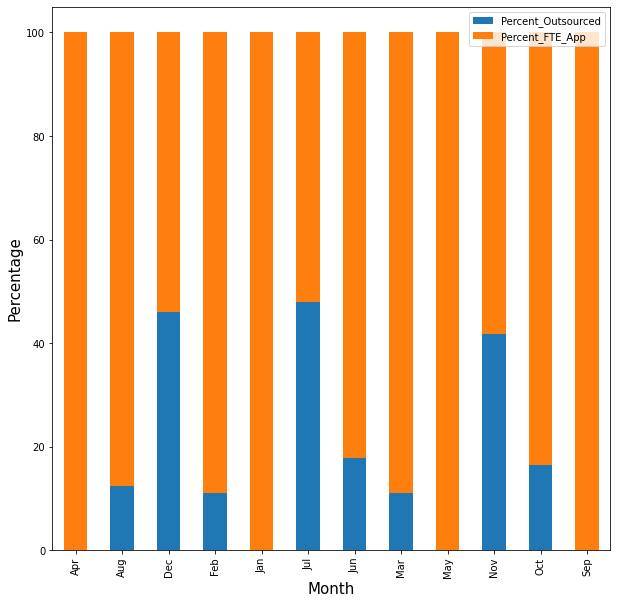

In [66]:
plt.figure(figsize= (25, 25))

model1_df[["Percent_Outsourced","Percent_FTE_App"]].plot(kind="bar", stacked=True, figsize=(10, 10))

plt.ylabel("Percentage", fontsize=15)
plt.xlabel("Month", fontsize=15)
plt.show()

#### For the month of April, January, May and September there is 100% FTEs and no application is outsourced. The outsourcing is above 40% for the months of December, July and November. 

### Cost per application increases with respect to any change in the parameters in the analysis

In [67]:
df_costperapp = pd.concat([output[['Month','Avg_CostperApp']], output_lb[['Avg_CostperApp']], output_ub[['Avg_CostperApp']]], axis=1)


In [68]:
df_costperapp.head()

,Month,Avg_CostperApp,Avg_CostperApp,Avg_CostperApp
0,Jan,154.32,178.57,138.89
1,Feb,164.47,188.62,147.06
2,Mar,166.67,178.57,156.25
3,Apr,156.25,166.67,147.06
4,May,160.26,178.57,147.06


In [69]:
df_costperapp = df_costperapp.groupby(['Month']).mean()
df_costperapp.head()

,Avg_CostperApp,Avg_CostperApp,Avg_CostperApp
Month,,,
Apr,145.833333,155.186667,137.253333
Aug,153.406667,171.463333,137.253333
Dec,171.463333,178.143333,164.843333
Feb,153.406667,171.463333,137.253333
Jan,144.033333,164.843333,129.630000


In [70]:
df_costperapp

,Avg_CostperApp,Avg_CostperApp,Avg_CostperApp
Month,,,
Apr,145.833333,155.186667,137.253333
Aug,153.406667,171.463333,137.253333
Dec,171.463333,178.143333,164.843333
Feb,153.406667,171.463333,137.253333
Jan,144.033333,164.843333,129.630000
Jul,167.926667,178.140000,155.186667
Jun,158.890000,171.466667,145.833333
Mar,155.186667,164.843333,145.833333
May,149.573333,164.840000,137.253333


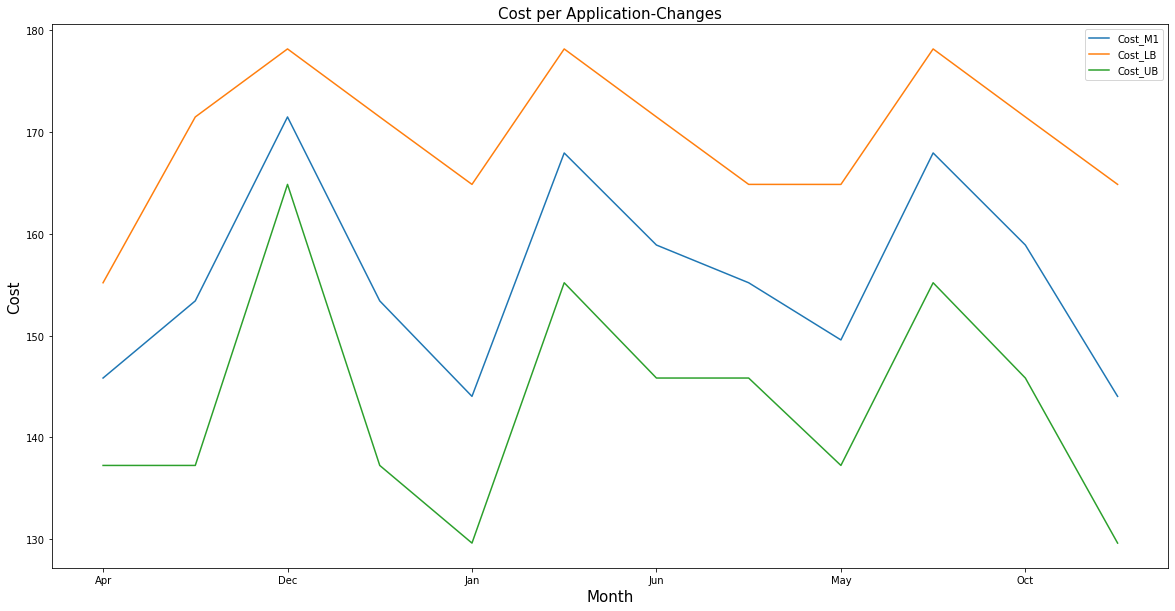

In [71]:
df_costperapp.plot.line(figsize=(20, 10))

plt.ylabel("Cost", fontsize=15)
plt.xlabel("Month", fontsize=15)
plt.legend(['Cost_M1', 'Cost_LB', "Cost_UB"])
plt.title("Cost per Application-Changes", fontsize=15)
plt.show()

#### Observations:

-	As per the above graph, the lower bound model where there is low availability of FTEs/staff, the cost increases. This is due to the increased outsourcing of applications. 
- When there is higher percentage of staff/FTEs availability the cost decreases, this is evident from the low outsourcing of applications. 
- Looking at the average staff availability model i.e. Model-1 (M1), this could be the usual scenario. 
